# Title of Experiment [ex. VGG-16 on CIFAR-10 Dataset]
*Author: Your Name*

## Objective
The goal of this notebook is to apply the `[model_name]` model on the CIFAR-10 dataset. 

## Resources
* **About `[model_name]`:**
[insert blurb about model]

* **About CIFAR-10**
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. http://www.cs.toronto.edu/~kriz/cifar.html

## 1.) Import packages and notebook settings

In [29]:
# requisite imports
import torch 
import tqdm
import os
import timeit

import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

import torch.optim as optim
import numpy as np
import random


**Device setting**: Devices with MPS available will use MPS, cuda will use cuda, and if both are not available, `device` is set to CPU.

In [30]:
device = torch.device('mps' if torch.backends.mps.is_available() else ('cuda:0' if torch.cuda.is_available() else 'cpu'))
print(device)

mps


**Seed Setting**:
Different sources of randomness contribute to the result of a neural network model. Nevertheless, a good neural network model should not depend on the eed but the data, architecture, and hyperparameters used. We introduce a seed value for the sake of reproducibility of our results. We set the `seed_value` to `42` for the following sources of randomness:
1. within the environment
2. within Python
3. within some packages like numpy and torch
4. and anywhere else where randomness is introduced like within architectures (some dropout layers introduce randomness) 


In [31]:
seed_value = 42

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(seed_value)

# 3. Set `numpy` and `torch` pseudo-random generator at a fixed value
np.random.seed(seed_value)
torch.manual_seed(seed_value)

**Variable setting**

In [2]:
BATCH_SIZE = 64
NUM_EPOCHS = 5
LR_LIST = [1E-3, 2E-5]


# 2.) Load and Transform CIFAR-10 dataset

The CIFAR-10 dataset is popular enough that `torchvision.datasets` has CIFAR-10 as one of its built-in datasets. https://pytorch.org/vision/stable/datasets.html#datasets

In [33]:
# Load the CIFAR train dataset
train = torchvision.datasets.CIFAR10("data/", train=True, download=True)
test = torchvision.datasets.CIFAR10("data/", train=False, download=True) 

Files already downloaded and verified
Files already downloaded and verified


**Transform**: Transforming a dataset when loading it is an important and common practice in computer vision. It is used for the following:
* *Data augmentation*: Increase the size and diversity of dataset, which can improve model performance. For ex., flip, rotate or crop images to create new images.
* *Normalization*: Normalize the distribution of hte pixel values, making the data easier for the model to learn.
* *Preprocessing*: Prepare data for a specific model, like perhaps you need to resize the images or convert them to another format.

Note: You can skip `transform` but it is not recommended. It may lead to overfitting, poor performance, or incompatibility of the data with the model you're using.

Resource on transformation: https://pytorch.org/vision/main/transforms.html

To start, I chose *normalization* for transformation.

In [34]:
# print(train.data) #train.data is of type numpy array 
# normalize train.data by dividing the array by 255. This will normalize all of the pixel values in the array between 0 and 1. 
# 255 is the max value for a pixel in a typical image.
normalized_train = train.data / 255
mean = normalized_train.mean(axis = (0,1,2))
std = normalized_train.std(axis = (0,1,2))
print(f"train mean: {mean}, train std: {std}")

train mean: [0.49139968 0.48215841 0.44653091], train std: [0.24703223 0.24348513 0.26158784]


We will feed these `mean` and `std` to the `transforms.v2.Compose()`

In [3]:
transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor(), transforms.Normalize(mean, std)])

# reload our train and test sets with transformation
train = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 
test = torchvision.datasets.CIFAR10("data/", train=True, download=False, transform=transform) 

# size of the validation set
val_size = 10000

# size of the train set
train_size = len(train) - val_size

# split the train into a train and a validation set, in accordance to the determined train and val sizes
generator1 = torch.Generator().manual_seed(seed_value) # keeps the split the same
train, val = random_split(train, [train_size, val_size], generator1)

# load the train, test, and val to our dataloader
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

NameError: name 'transforms' is not defined

**Double check** if train and val are consistent across all notebooks.
* The first 10 of train.indices should be [37542, 44491, 216, 43688, 41558, 32245, 27206, 10863, 2190, 31849]
* The first 10 of val.indices should be [4938, 8171, 41491, 25867, 39987, 37309, 48959, 30619, 45749, 27682]

In [57]:
print("train indices,", train.indices[:10]) # check with values above if match
print("val indices,", val.indices[:10]) # check the first ten

train indices, [37542, 44491, 216, 43688, 41558, 32245, 27206, 10863, 2190, 31849]
val indices, [4938, 8171, 41491, 25867, 39987, 37309, 48959, 30619, 45749, 27682]


**Visualizing images**

In [36]:
def imshow(img):
    img_np = img.numpy()
    img_np = img_np / 2 + 0.5 # unnormalize image
    plt.axis('off')
    plt.imshow(np.transpose(img_np, (1,2,0)))
    plt.show
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cat cat deer frog plane horse cat cat ship deer frog deer car plane dog truck car dog frog car horse truck plane bird cat frog car truck plane frog cat deer truck horse dog deer plane cat car bird ship ship cat dog horse truck plane ship bird truck truck ship plane ship bird horse car plane truck dog car cat truck ship


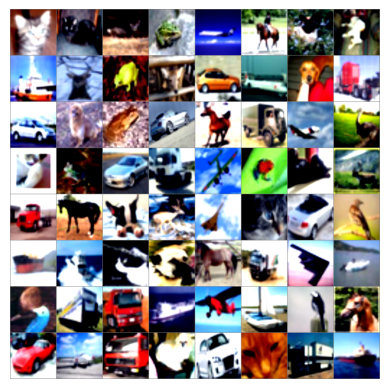

In [37]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]}' for j in range(BATCH_SIZE)))

## 3.0 Define a [model_name] Neural Network (skip if using a pre-trained model)

**How models work in PyTorch**
Every custom model is inherited from the `nn.Module` class. This class provides basic functionality that helps the model to train. There are 2 main things we need to define:
* `__init__`
* `forward`

**Types of layers and definitions**

* `nn.Conv2d`: convolutional layers that accepts no. of input and output channels as args, along with kernel size for the filter. It accepts strides and paddings as well, if you wish to implement this.
* `nn.Batchnormd2`: batch normalization layers for the output of the convolutional layers.
* `nn.ReLU`: an activation layer applied to the outputs in the network.
* `nn.MaxPool2d`: max pooling layer to the output with the given kernel size
* `nn.DropOut`: dropout regularization layer with a given probability
* `nn.Linear`: essentially a fully connected layer
* `nn.Sequential`: not really a layer, but combines different operations part of the same step

In [38]:
model_name = "Name_of_model"
model = ...

## 3.1 Fine-tune a Pretrained [model_name] model (skip if training from scratch (using 3.0))

**Define a loss function and optimizer**

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer_list = [optim.SGD(model.parameters(), lr=LR_LIST[0], momentum=0.9),
                      optim.Adam(model.parameters(), lr=LR_LIST[0]),
                      optim.SGD(model.parameters(), lr=LR_LIST[1], momentum=0.9),
                      optim.Adam(model.parameters(), lr=LR_LIST[1])]
# scheduler defined in the training loop

## 4. Train the model

We simply have a function that takes in our data loaders, the model, our optimizer, a scheduler, a loss function, epochs, and whether if we want to use scheduler or not. We keep track of train_losses, val_losses, and the times for when the model is finished.

In [ ]:
def train_loop(tr_loader, vl_loader, model, optimizer, loss_fn, epochs, use_scheduler=True):
    """
    Abstract training loop for a deep learning model.

    Parameters:
    - tr_loader: input loader for the training inputset.
    - vl_loader: input loader for the validation set.
    - model: The neural network model to train.
    - optimizer: The optimization algorithm.
    - loss_fn: Loss function.
    - epochs: Number of training epochs.
    - use_scheduler: Whether to use a learning rate scheduler.

    Returns:
    - Trained model.
    - Report with training and validation losses and accuracies over epochs
    """
    # scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

    print("Started training on ", device)
    model.to(device)


    train_losses_history = [] # collect train and val losses so we can inspect learning curve of model
    val_losses_history = []
    train_corrects_history = [] # collect train and val corrects / accuracy scores
    val_corrects_history = []
    epoch_times_history = []  # collect times it takes for each epoch

    tq = tqdm.tqdm(range(epochs)) # creates a tqdm progress bar that will iterate over the range of epochs, useful for tracking progress

    for e in tq:
        train_loss = 0.0
        val_loss = 0.0
        train_corrects = 0.0
        val_corrects = 0.0
        start_time = timeit.default_timer()

        # Training Step
        for inputs, labels in tr_loader: # for each input and label in the data loader per batch
            inputs, labels = inputs.to(device), labels.to(device) # push input and labels to device since model is running in device
            outputs = model(inputs) # push inputs to the model, which will output the predictions

            loss = loss_fn(outputs, labels) # calculate the loss after each batch by comparing it to actual labels
            optimizer.zero_grad() # set the initial gradient to 0
            loss.backward() # backpropagate the loss
            optimizer.step() # udpate weights and biases for every single step

            _, preds = torch.max(outputs, 1) # take the highest value of prediction
            train_loss += loss.item() # update train_loss value
            train_corrects += torch.sum(preds == labels) # calculate accuracy by taking sum of all the predictions in a batch

        if use_scheduler:
            scheduler.step()

        end_time = timeit.default_timer() # timer ends when training ends

        # Validation Step
        with torch.no_grad(): # we do not need gradients for validation
            for val_inputs, val_labels in vl_loader: # similar to training step
                val_inputs, val_labels = val_inputs.to(device), val_labels.to(device)
                val_outputs = model(val_inputs)
                val_loss = loss_fn(val_outputs, val_labels)

                _, val_preds = torch.max(val_outputs, 1)
                val_loss += val_loss.item()
                val_corrects += torch.sum(val_preds == val_labels.data.to(device))

        # Report Step: calculate our train and val losses, accuracies and epoch times
        train_epoch_loss = train_loss/(len(tr_loader)*BATCH_SIZE)
        train_epoch_acc = train_corrects.float()/(len(tr_loader)*BATCH_SIZE)
        train_losses_history.append(train_epoch_loss) # to visualize learning curve through epoch
        train_corrects_history.append(train_epoch_acc.cpu().numpy()) # to visualize accuracy through epoch

        val_epoch_loss = val_loss/(len(vl_loader)*BATCH_SIZE)
        val_epoch_acc = val_corrects.float()/(len(vl_loader)*BATCH_SIZE)
        val_losses_history.append(val_epoch_loss)
        val_corrects_history.append(val_epoch_acc.cpu().numpy())
        epoch_times_history.append(end_time - start_time)

        # Create a report out of the model loss, accuracies, and times
        report = {'train_losses_history': train_losses_history,
                  'train_corrects_history': train_corrects_history,
                  'val_losses_history': val_losses_history,
                  'val_corrects_history': val_corrects_history,
                  'epoch_times_history': epoch_times_history}

        print('epoch:', (e+1))
        print(f'training loss: {train_epoch_loss}, training accuracy: {train_epoch_acc}')
        print(f'validation loss: {val_epoch_loss}, validation accuracy: {val_epoch_acc}')
        print(model)
        print(report)

    print("Finished training.")
    return model, report

In [ ]:
trained_model, training_report = train_loop(train_loader, val_loader, model, optimizer, criterion, 5, use_scheduler=True)

**Visualizing train and test plots**

In [4]:
def plot_graphs(report_dict, save_folder='./performance_data/vgg16_plots/model'):
    # Ensure the save folder exists, create it if it doesn't
    os.makedirs(save_folder, exist_ok=True)

    # Plot train vs val losses
    plt.style.use("ggplot")
    plt.title("Train and Val Loss Plot")
    plt.plot(report_dict['train_losses_history'], label="train loss")
    plt.plot(report_dict['val_losses_history'], label="val loss")
    plt.legend()

    save_path = os.path.join(save_folder, 'loss_plot.png')
    plt.savefig(save_path)
    plt.show()

    # Plot train vs val corrects
    plt.style.use("ggplot")
    plt.title("Train and Val Accuracy Plot")
    plt.plot(report_dict['train_corrects_history'], label="train accuracy")
    plt.plot(report_dict['val_corrects_history'], label="val accuracy")
    plt.legend()

    save_path = os.path.join(save_folder, 'corrects_plot.png')
    plt.savefig(save_path)
    plt.show()

    # Plot train vs val corrects
    plt.style.use("ggplot")
    plt.title("Epochs time Plot")
    plt.plot(report_dict['epoch_times_history'], label="epoch time")
    plt.legend()
    save_path = os.path.join(save_folder, 'epochs_time_plot.png')
    plt.savefig(save_path)
    plt.show()

**Saving the model**

In [ ]:
PATH = f"./cifar_{model_name}_v1.pth"
torch.save(model.state_dict(), PATH)

## 5. Evaluate model

In [1]:
def evaluate_model(model, ts_loader):
  accuracy = evaluate_model_as_whole(model, ts_loader)
  accuracies_per_class = evaluate_model_per_class(model, ts_loader)
  return accuracy, accuracies_per_class

def evaluate_model_as_whole(model, ts_loader):
    correct = 0
    total = 0
    accuracy = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in ts_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = model(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy of the network on the 10000 test images: {accuracy} %')

    return accuracy

def evaluate_model_per_class(model, ts_loader):
    accuracies_per_class = {}
    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in ts_loader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')
        accuracies_per_class[classname] = accuracy

    return accuracies_per_class